In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from os.path import join
import sys
import json
idx = pd.IndexSlice

### Date string for filenames
This will be inserted into all filenames (reading and writing)

In [2]:
file_date = '2018-03-06'

In [3]:
%load_ext watermark

In [4]:
%watermark -v -iv

seaborn     0.8.1
pandas      0.22.0
numpy       1.14.1
json        2.0.9
CPython 3.6.4
IPython 6.2.1


In [5]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [6]:
# add the 'src' directory as one where we can import modules
src_dir = join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [7]:
%aimport Data.make_data
from Data.make_data import states_in_nerc
%aimport Analysis.index
from Analysis.index import facility_emission_gen, group_facility_data
%aimport Analysis.index
from Analysis.index import facility_co2, adjust_epa_emissions, group_fuel_cats
from Analysis.index import reduce_emission_factors, add_datetime
%aimport util.utils
from util.utils import rename_cols, add_facility_location

## Extra NERC emissions and generation

### Load extra NERC generation and fuel consumption

In [8]:
cwd = os.getcwd()
path = join(cwd, '..', 'Data storage', 'Derived data',
            'NERC extra gen fuels {}.csv'.format(file_date))
extra_nerc = pd.read_csv(path, index_col=[0, 1, 2, 3])

In [9]:
extra_nerc.head()

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)
year nerc month type                                                         
2016 FRCC 1     COW           0.004112        2.668777e+00      -1.346289e+00
                HYC           0.002000       -3.253440e+05      -3.253440e+05
                NG            0.002867       -1.883063e+00       1.916231e+00
                OTH           0.000975       -3.980957e+06      -3.690502e+06
                PEL           0.001999       -3.999099e+00       9.995208e-01

### Load emission factors

In [10]:
path = join(cwd, '..', 'Data storage', 'Final emission factors.csv')
ef = pd.read_csv(path, index_col=0)

In [11]:
ef.head()

,Fuel,Fossil Factor,Notes,Link,Total Factor
EIA Fuel Code,,,,,
BIT,Bituminous Coal,93.30,NaN,https://www.eia.gov/electricity/annual/html/ep...,93.30
DFO,Distillate Fuel Oil,73.16,NaN,https://www.eia.gov/electricity/annual/html/ep...,73.16
GEO,Geothermal,7.71,NaN,https://www.eia.gov/electricity/annual/html/ep...,7.71
JF,Jet Fuel,70.90,NaN,https://www.eia.gov/electricity/annual/html/ep...,70.90
KER,Kerosene,72.30,NaN,https://www.eia.gov/electricity/annual/html/ep...,72.30


In [12]:
ef_type = reduce_emission_factors(ef)

In [13]:
ef_type = pd.Series(ef_type, name='type')
ef_type

COW     95.250
NG      53.070
OOG     59.000
PC     102.100
PEL     75.975
Name: type, dtype: float64

### Calculate CO₂ emissions

In [14]:
extra_nerc.loc[:, 'total co2 (kg)'] = (extra_nerc
                                       .loc[:, 'total fuel (mmbtu)']
                                       .multiply(ef_type, 'type'))
extra_nerc.loc[:, 'elec co2 (kg)'] = (extra_nerc
                                       .loc[:, 'elec fuel (mmbtu)']
                                       .multiply(ef_type, 'type'))

In [15]:
extra_nerc.sort_index(inplace=True)
extra_nerc.head()

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)  \
year nerc month type                                                            
2016 FRCC 1     COW           0.004112        2.668777e+00      -1.346289e+00   
                HYC           0.002000       -3.253440e+05      -3.253440e+05   
                NG            0.002867       -1.883063e+00       1.916231e+00   
                OTH           0.000975       -3.980957e+06      -3.690502e+06   
                PEL           0.001999       -3.999099e+00       9.995208e-01   

                      total co2 (kg)  elec co2 (kg)  
year nerc month type                                 
2016 FRCC 1     COW       254.201050    -128.233995  
                HYC              NaN            NaN  
                NG        -99.934141     101.694366  
                OTH              NaN            NaN  
                PEL      -303.831527      75.938596

## Facilities by NERC

In [16]:
%aimport Analysis.state2nerc
from Analysis.state2nerc import fraction_state2nerc, add_region

In [17]:
fuel_cat_folder = join(cwd, '..', 'Data storage', 'Fuel categories')
state_cats_path = join(fuel_cat_folder, 'State_facility.json')

with open(state_cats_path, 'r') as f:
    state_fuel_cat = json.load(f)
    
custom_cats_path = join(fuel_cat_folder, 'Custom_results.json')
with open(custom_cats_path, 'r') as f:
    custom_fuel_cat = json.load(f)

In [18]:
path = join(cwd, '..', 'Data storage', 'Derived data',
            'Monthly EPA emissions {}.csv'.format(file_date))
epa = pd.read_csv(path)

In [19]:
path = join(cwd, '..', 'Data storage', 'Facility labels',
            'Facility locations_knn.csv')
facility_labels = pd.read_csv(path)

In [20]:
path = join(cwd, '..', 'Data storage', 'Derived data',
            'Facility gen fuels and CO2 {}.csv'.format(file_date))
eia_fac = pd.read_csv(path)

In [21]:
eia_fac.head()

,f,fuel,month,plant id,total fuel (mmbtu),year,generation (MWh),elec fuel (mmbtu),geography,last_updated,lat,lon,prime mover,datetime,quarter,all fuel fossil CO2 (kg),elec fuel fossil CO2 (kg),all fuel total CO2 (kg),elec fuel total CO2 (kg)
0,M,DFO,12,1001,1116.0,2017,114.587,1116.0,USA-IN,2018-02-28T02:03:13-05:00,39.9242,-87.4244,ALL,2017-12-01,4,81646.56,81646.56,81646.56,81646.56
1,M,DFO,11,1001,2772.0,2017,265.428,2772.0,USA-IN,2018-02-28T02:03:13-05:00,39.9242,-87.4244,ALL,2017-11-01,4,202799.52,202799.52,202799.52,202799.52
2,M,DFO,10,1001,4819.0,2017,460.695,4819.0,USA-IN,2018-02-28T02:03:13-05:00,39.9242,-87.4244,ALL,2017-10-01,4,352558.04,352558.04,352558.04,352558.04
3,M,DFO,9,1001,2720.0,2017,300.705,2720.0,USA-IN,2018-02-28T02:03:13-05:00,39.9242,-87.4244,ALL,2017-09-01,3,198995.20,198995.20,198995.20,198995.20
4,M,DFO,8,1001,6273.0,2017,609.358,6273.0,USA-IN,2018-02-28T02:03:13-05:00,39.9242,-87.4244,ALL,2017-08-01,3,458932.68,458932.68,458932.68,458932.68


In [22]:
co2, gen_fuels_state = facility_emission_gen(eia_facility=eia_fac, epa=epa,
                                              state_fuel_cat=state_fuel_cat,
                                              custom_fuel_cat=custom_fuel_cat,
                                              export_state_cats=True)

Renaming columns
Grouping facilities
Adjusting EPA emissions
Caculating CO2
Gen/fuels to state categories


### Monthly CO₂ emissions

In [23]:
co2 = add_facility_location(co2, facility_labels, labels=['lat', 'lon', 'state', 'nerc'])

In [24]:
co2_nerc = co2.groupby(['year', 'nerc', 'month'])['final co2 (kg)'].sum()

In [25]:
co2_nerc.tail()

year  nerc  month
2017  WECC  8        2.730900e+10
            9        2.301635e+10
            10       2.127247e+10
            11       2.029870e+10
            12       2.134598e+10
Name: final co2 (kg), dtype: float64

### Monthly generation

In [26]:
gen_fuels_nerc = add_facility_location(gen_fuels_state, facility_labels, labels=['nerc'])
gen_fuels_nerc = (gen_fuels_nerc
                  .groupby(['year', 'nerc', 'month', 'type'])
                  ['generation (mwh)'].sum())
gen_fuels_nerc.head()

year  nerc  month  type
2001  ASCC  1      COW      26493.302
                   HYC     103940.302
                   NG      314206.726
                   PEL      64782.245
                   WND         86.518
Name: generation (mwh), dtype: float64

In [27]:
gen_fuels_nerc.tail()

year  nerc  month  type
2017  WECC  12     PEL       24138.457
                   SUN      723979.000
                   WAS      150435.111
                   WND     1008289.000
                   WWW      159861.530
Name: generation (mwh), dtype: float64

In [28]:
gen_fuels_nerc.loc[idx[2015, 'NPCC', :, :]].groupby(['year', 'nerc', 'month']).sum()

year  nerc  month
2015  NPCC  1        2.087961e+07
            2        2.026406e+07
            3        1.990096e+07
            4        1.806322e+07
            5        2.006970e+07
            6        2.068304e+07
            7        2.449400e+07
            8        2.442134e+07
            9        2.127549e+07
            10       1.934880e+07
            11       1.842305e+07
            12       1.958938e+07
Name: generation (mwh), dtype: float64

## Combine generation

In [29]:
extra_nerc.head()

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)  \
year nerc month type                                                            
2016 FRCC 1     COW           0.004112        2.668777e+00      -1.346289e+00   
                HYC           0.002000       -3.253440e+05      -3.253440e+05   
                NG            0.002867       -1.883063e+00       1.916231e+00   
                OTH           0.000975       -3.980957e+06      -3.690502e+06   
                PEL           0.001999       -3.999099e+00       9.995208e-01   

                      total co2 (kg)  elec co2 (kg)  
year nerc month type                                 
2016 FRCC 1     COW       254.201050    -128.233995  
                HYC              NaN            NaN  
                NG        -99.934141     101.694366  
                OTH              NaN            NaN  
                PEL      -303.831527      75.938596

In [30]:
extra_nerc.loc[idx[2016, 'NPCC', :, 'COW']].groupby(['year', 'nerc', 'month']).sum()

generation (mwh)  total fuel (mmbtu)  elec fuel (mmbtu)  \
year nerc month                                                            
2016 NPCC 1                 0.002                 2.0               -2.0   
          2                 0.002                 5.0                2.0   
          3                 0.010                 5.0                6.0   
          4                -0.002                 2.0               -2.0   
          5                -0.003                 2.0                1.0   
          6                 0.009                10.0                2.0   
          7                 0.003               -11.0               -3.0   
          8                 0.010                 3.0               -8.0   
          9                -0.001                 1.0                9.0   
          10                0.002                 2.0                3.0   
          11                0.008                 3.0                2.0   
          12                0.002                -4.0                2.0   

                 total co2 (kg)  elec co2 (kg)  
year nerc month                                 
2016 NPCC 1              190.50        -190.50  
          2              476.25         190.50  
          3              476.25         571.50  
          4              190.50        -190.50  
          5              190.50          95.25  
          6              952.50         190.50  
          7            -1047.75        -285.75  
          8              285.75        -762.00  
          9               95.25         857.25  
          10             190.50         285.75  
          11             285.75         190.50  
          12            -381.00         190.50

In [31]:
total_gen = gen_fuels_nerc.copy()
# total_gen.loc[idx[2015:, 'RFC', :, :]]

In [32]:
total_gen.loc[idx[2016:, :, :, :]] = (total_gen.loc[2016:] 
                                     .add(extra_nerc.loc[:, 'generation (mwh)']
                                          , fill_value=0))
total_gen = total_gen.reset_index()
add_datetime(total_gen)
# total_gen.set_index(['year', 'nerc', ''])

In [33]:
total_gen.head()

,year,nerc,month,type,generation (mwh),datetime
0,2001,ASCC,1,COW,26493.302,2001-01-01
1,2001,ASCC,1,HYC,103940.302,2001-01-01
2,2001,ASCC,1,NG,314206.726,2001-01-01
3,2001,ASCC,1,PEL,64782.245,2001-01-01
4,2001,ASCC,1,WND,86.518,2001-01-01


In [34]:
final = group_fuel_cats(total_gen,
                        custom_fuel_cat, 'type',
                        'fuel category', extra_group_cols=['nerc', 'datetime'])
final.set_index(['nerc', 'fuel category', 'datetime'], inplace=True)

In [35]:
final.head()

,,,year,month,generation (mwh)
nerc,fuel category,datetime,,,
ASCC,Coal,2001-01-01,2001,1,2.649330e+04
FRCC,Coal,2001-01-01,2001,1,6.032943e+06
HICC,Coal,2001-01-01,2001,1,1.341608e+05
MRO,Coal,2001-01-01,2001,1,1.327117e+07
NPCC,Coal,2001-01-01,2001,1,4.318327e+06


In [36]:
final.tail()

,,,year,month,generation (mwh)
nerc,fuel category,datetime,,,
RFC,Wind,2017-12-01,2017,12,2.407732e+06
SERC,Wind,2017-12-01,2017,12,3.733354e+05
SPP,Wind,2017-12-01,2017,12,4.974190e+06
TRE,Wind,2017-12-01,2017,12,4.866436e+06
WECC,Wind,2017-12-01,2017,12,3.147145e+06


In [37]:
total = final.groupby(['nerc', 'datetime']).sum()
# total.reset_index(inplace=True)
# add_datetime(total)
# total['fuel category'] = 'Total'
total.head()

year  month  generation (mwh)
nerc datetime                                  
ASCC 2001-01-01  10005      5        509509.093
     2001-02-01  10005     10        456570.631
     2001-03-01  10005     15        492752.208
     2001-04-01  10005     20        416745.544
     2001-05-01  10005     25        408946.508

In [38]:
nercs = total.index.get_level_values('nerc').unique()

### Percent generation by fuel
    

In [39]:
df_list = []
for nerc in nercs:
    percent_gen = final.loc[nerc].divide(total.loc[nerc], level='datetime')
    percent_gen['nerc'] = nerc
    percent_gen.set_index('nerc', append=True, inplace=True)
    df_list.append(percent_gen)
    
percent_gen = pd.concat(df_list)
percent_gen.drop(['year', 'month'], axis=1, inplace=True)
percent_gen.columns = ['% generation']

In [40]:
percent_gen.head()

% generation
fuel category datetime   nerc              
Coal          2001-01-01 ASCC      0.051998
              2001-02-01 ASCC      0.068475
              2001-03-01 ASCC      0.057757
              2001-04-01 ASCC      0.049085
              2001-05-01 ASCC      0.058924

In [41]:
percent_gen.sort_index().loc[idx['Wind', :, 'SPP'], :]

% generation
fuel category datetime   nerc              
Wind          2001-12-01 SPP       0.004024
              2002-01-01 SPP       0.003390
              2002-02-01 SPP       0.004475
              2002-03-01 SPP       0.004750
              2002-04-01 SPP       0.004879
              2002-05-01 SPP       0.004433
              2002-06-01 SPP       0.003600
              2002-07-01 SPP       0.002133
              2002-08-01 SPP       0.002530
              2002-09-01 SPP       0.002867
              2002-10-01 SPP       0.002823
              2002-11-01 SPP       0.003400
              2002-12-01 SPP       0.003074
              2003-01-01 SPP       0.002991
              2003-02-01 SPP       0.002843
              2003-03-01 SPP       0.004401
              2003-04-01 SPP       0.005039
              2003-05-01 SPP       0.003430
              2003-06-01 SPP       0.002309
              2003-07-01 SPP       0.002568
              2003-08-01 SPP       0.001982
              2003-09-01 SPP       0.003240
              2003-10-01 SPP       0.003083
              2003-11-01 SPP       0.003904
              2003-12-01 SPP       0.007363
              2004-01-01 SPP       0.005239
              2004-02-01 SPP       0.006250
              2004-03-01 SPP       0.007606
              2004-04-01 SPP       0.007366
              2004-05-01 SPP       0.008773
...                                     ...
              2015-07-01 SPP       0.097514
              2015-08-01 SPP       0.092048
              2015-09-01 SPP       0.144196
              2015-10-01 SPP       0.147812
              2015-11-01 SPP       0.209035
              2015-12-01 SPP       0.185220
              2016-01-01 SPP       0.157545
              2016-02-01 SPP       0.220237
              2016-03-01 SPP       0.247169
              2016-04-01 SPP       0.234039
              2016-05-01 SPP       0.195901
              2016-06-01 SPP       0.133662
              2016-07-01 SPP       0.145072
              2016-08-01 SPP       0.115024
              2016-09-01 SPP       0.163217
              2016-10-01 SPP       0.247822
              2016-11-01 SPP       0.225534
              2016-12-01 SPP       0.200701
              2017-01-01 SPP       0.226313
              2017-02-01 SPP       0.272240
              2017-03-01 SPP       0.301908
              2017-04-01 SPP       0.330530
              2017-05-01 SPP       0.254924
              2017-06-01 SPP       0.198277
              2017-07-01 SPP       0.141674
              2017-08-01 SPP       0.121146
              2017-09-01 SPP       0.209842
              2017-10-01 SPP       0.300563
              2017-11-01 SPP       0.276251
              2017-12-01 SPP       0.253897

[193 rows x 1 columns]

In [42]:
path = join(cwd, '..', 'Data storage', 'Final NERC data',
            'NERC percent gen {}.csv'.format(file_date))
percent_gen.to_csv(path)

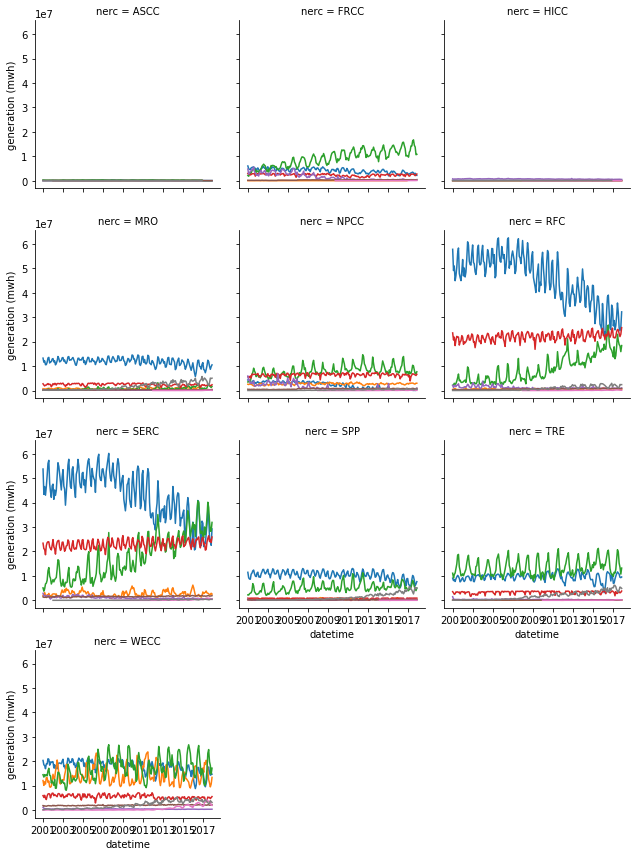

In [43]:
g = sns.FacetGrid(final.reset_index(), col='nerc', col_wrap=3, hue='fuel category')
g.map(plt.plot, 'datetime', 'generation (mwh)')

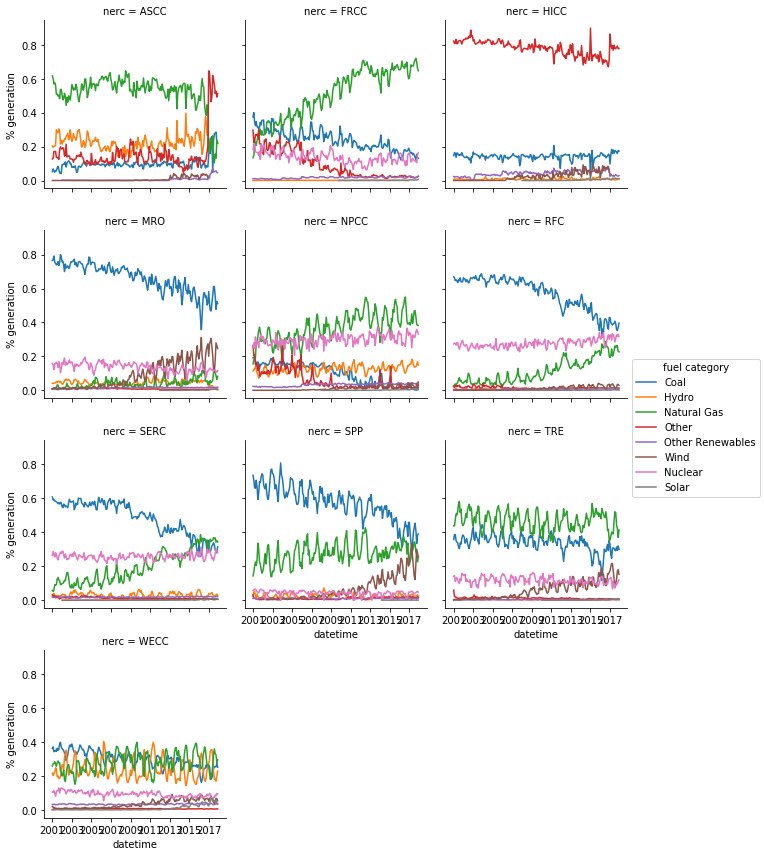

In [44]:
g = sns.FacetGrid(percent_gen.reset_index(), col='nerc', col_wrap=3, hue='fuel category')
g.map(plt.plot, 'datetime', '% generation').add_legend()

In [45]:
total_monthly_gen = final.groupby(['fuel category', 'year', 'nerc', 'month']).sum()
total_monthly_gen.sort_index(inplace=True)

In [46]:
total_monthly_gen.head()

generation (mwh)
fuel category year nerc month                  
Coal          2001 ASCC 1             26493.302
                        2             31263.704
                        3             28459.894
                        4             20455.924
                        5             24096.734

In [47]:
nercs

Index(['ASCC', 'FRCC', 'HICC', 'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE',
       'WECC'],
      dtype='object', name='nerc')

In [52]:
path = join(cwd, '..', 'Data storage', 'Final NERC data',
            'NERC generation {}.csv'.format(file_date))
total_monthly_gen.to_csv(path)

## CO₂ emissions intensity by NERC region

In [49]:
co2_nerc.head()

year  nerc  month
2001  ASCC  1        2.776167e+08
            2        2.687019e+08
            3        2.937043e+08
            4        2.354016e+08
            5        2.303100e+08
Name: final co2 (kg), dtype: float64

In [50]:
type(co2_nerc), type(total_monthly_gen)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [48]:
total_monthly_gen = total_monthly_gen.groupby(['year', 'nerc', 'month']).sum()

In [49]:
nerc_index = pd.concat([co2_nerc.sort_index(), total_monthly_gen.sort_index()], axis=1)
nerc_index['index'] = nerc_index['final co2 (kg)'] / nerc_index['generation (mwh)']
nerc_index = nerc_index.reset_index()
add_datetime(nerc_index)

In [50]:
nerc_index.tail()

,year,nerc,month,final co2 (kg),generation (mwh),index,datetime
2035,2017,WECC,8,2.730900e+10,6.893889e+07,396.133437,2017-08-01
2036,2017,WECC,9,2.301635e+10,5.995524e+07,383.892221,2017-09-01
2037,2017,WECC,10,2.127247e+10,5.624146e+07,378.234615,2017-10-01
2038,2017,WECC,11,2.029870e+10,5.300900e+07,382.929310,2017-11-01
2039,2017,WECC,12,2.134598e+10,5.847142e+07,365.066908,2017-12-01


### Write data to file

In [51]:
nerc_index.head()

,year,nerc,month,final co2 (kg),generation (mwh),index,datetime
0,2001,ASCC,1,2.776167e+08,509509.093,544.870957,2001-01-01
1,2001,ASCC,2,2.687019e+08,456570.631,588.522012,2001-02-01
2,2001,ASCC,3,2.937043e+08,492752.208,596.048720,2001-03-01
3,2001,ASCC,4,2.354016e+08,416745.544,564.856988,2001-04-01
4,2001,ASCC,5,2.303100e+08,408946.508,563.178907,2001-05-01


In [53]:
path = join(cwd, '..', 'Data storage', 'Final NERC data',
            'NERC gen emissions and index {}.csv'.format(file_date))
nerc_index.to_csv(path, index=False)